In [313]:
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import re
import math
from collections import Counter
from turtle import distance
from scipy import stats
from networkx.algorithms.community import greedy_modularity_communities

### 1.4

In [170]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5,6,7,8,9])
G.add_edges_from([(1, 2), (1, 4), (1, 7), (1, 9)])
G.add_edges_from([(2, 3), (2, 5), (2, 8)])
G.add_edges_from([(3, 4), (3, 6)])
G.add_edges_from([(4, 5)])
G.add_edges_from([(5, 6), (5, 9)])
G.add_edges_from([(6, 7)])
G.add_edges_from([(7, 8)])
G.add_edges_from([(8, 9)])
# G.add_edges_from([(9, 1), (9, 5), (9, 6), (9, 8)])
# G.to_undirected()

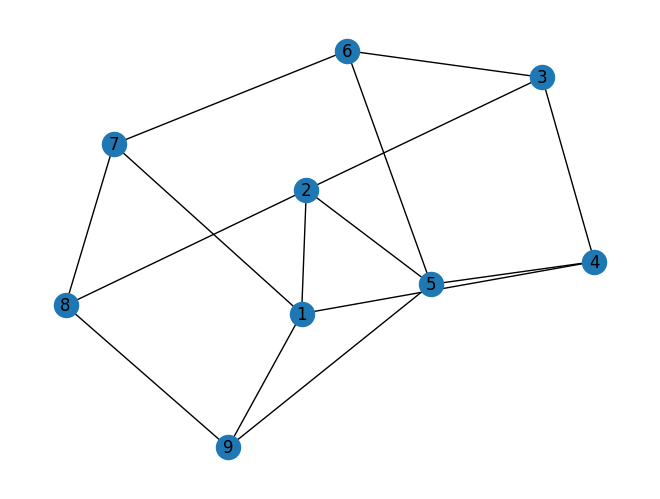

In [171]:
# Draw graph
nx.draw(G, with_labels=True)

In [172]:
print(nx.average_clustering(G))

0.0


---

### 3.1

In [173]:
import numpy as np
import csv
import networkx as nx

Load twitter-small.tsv

In [174]:
tsvfile =  open("../datasets/twitter-small.tsv", encoding='gb18030', errors='ignore')
tsvReader = [each for each in csv.reader(tsvfile, delimiter='\t')]
tsvfile.close()

*Question1 : 'gbk' codec can't decode byte 0xaa in position 1444: illegal multibyte sequence*  
*Solution: encoding='gb18030', errors='ignore'*

In [175]:
# # find all word_index in a list
# def find_all_mention(alist, word):
#     start_index = -1
#     find_list = []
#     while(True):
#         current_find = alist.find(word, start_index+1)
#         if current_find == -1:
#             break
#         stop_point1 = alist.find(' ', current_find)
#         stop_point2 = alist.find(':', current_find)
#         if stop_point2 != -1:
#             stop_index = stop_point1 if stop_point1 < stop_point2 else stop_point2
#         else:
#             stop_index = stop_point1
#         start_index = current_find

#         find_list.append(alist[start_index+1 : stop_index]) 
#     return find_list

In [176]:
# find all word_index in a list
def find_all_user(alist):
    mention_list =  re.findall('@[a-zA-Z0-9_]{0,15}', alist)
    if len(mention_list) == 0:
        return -1
    for user in mention_list:
        i = 0
        if (user == '') | (user == '@'):
            del mention_list[i]
        i += 1
    return mention_list
    

In [177]:
# edges_weights_dictionary
Gs_dic = {}
for row in tsvReader:
    # row[0] : timestamp
    # row[1] : user
    # row[2] : tweet
    mention = find_all_user(row[2])
    if mention != -1:
        for each in mention:
            if len(each) != 0:
                if (row[1], each) not in Gs_dic.keys():
                    Gs_dic[(row[1], each)] = [row[0], 1]
                else:
                    Gs_dic[(row[1], each)][1] += 1

In [178]:
def preprocessing_Timestamp(timestamp):
    retimestamp = timestamp[:10]+'T'+timestamp[11:]
    return retimestamp

In [179]:
# edge .csv with weights
with open("../datasets/twitter_weight_small.csv","w") as csvWrite: 
    nwriter = csv.writer(csvWrite,delimiter=' ')
    nwriter.writerow(['Source', 'Target', 'Weight', 'Timestamp'])
    for key in sorted(Gs_dic.keys()):
        timestamp = preprocessing_Timestamp(Gs_dic[key][0])
        if (key[0] != '') & (key[1][1:] != '') & (key[0] != key[1][1:]):
            nwriter.writerow([key[0],key[1][1:],Gs_dic[key][1],timestamp])

csvWrite.close()

In [180]:
# edge .csv without weights
with open("../datasets/twitter_small.csv","w") as csvWrite: 
    nwriter = csv.writer(csvWrite,delimiter=' ')
    nwriter.writerow(['Source', 'Target'])
    for key in sorted(Gs_dic.keys()):
        timestamp = preprocessing_Timestamp(Gs_dic[key][0])
        if (key[0] != '') & (key[1][1:] != '') & (key[0] != key[1][1:]):
            nwriter.writerow([key[0],key[1][1:]])

csvWrite.close()

In [181]:
# edge .csv  adjlist list
Gs = nx.read_adjlist("../datasets/twitter_small.csv", create_using=nx.DiGraph())

with open("../datasets/twitter_adjust_small.csv","w") as csvWrite: 
    nwriter = csv.writer(csvWrite,delimiter=' ')
    for line in nx.generate_adjlist(Gs):
        nwriter.writerow([line])
csvWrite.close()

---

### 3.2

#### 3.2.1

In [182]:
Gs = nx.read_adjlist("../datasets/twitter_small.csv", create_using=nx.DiGraph())

In [183]:
print('nodes: ', Gs.number_of_nodes())
print('edges: ', Gs.number_of_edges())

nodes:  65439
edges:  67828


#### 3.2.2

In [184]:
def count_nodes(G, Gtype):
    subGraph = []
    count_nodes = 0
    count_edges = 0
    if Gtype == 'strongly':
        Gc = nx.strongly_connected_components(G)
        count_component = nx.number_strongly_connected_components(G)
    else:
        Gc = nx.weakly_connected_components(G)
        count_component = nx.number_weakly_connected_components(G)
    return [count_component, Gc]

In [185]:
Gs_strongly_num, Gs_strongly_size_list = count_nodes(Gs, "strongly")
Gs_weakly_num, Gs_weakly_size_list = count_nodes(Gs, "weakly")

In [186]:
print('The number of strongly connected components: ', Gs_strongly_num)
print('The number of weakly connected components: ', Gs_weakly_num)

The number of strongly connected components:  65061
The number of weakly connected components:  10780


In [187]:
def count_size_each_components(G, G_componnents):
    size_list = []
    for each_componnent in G_componnents:
        g = G.subgraph(each_componnent)
        size_list.append(g.number_of_nodes())
    return sorted(size_list,reverse=True)

In [188]:
size_list_strongly = count_size_each_components(Gs, Gs_strongly_size_list)
size_list_weakly = count_size_each_components(Gs, Gs_weakly_size_list)

In [189]:
def count_frequency(size_list):
    size_frequency = {}
    for i in size_list:
        if i not in size_frequency.keys():
            size_frequency[i] = 1
        else:
            size_frequency[i] += 1
    return size_frequency


In [190]:
size_frequency_strongly = {}
size_frequency_strongly = count_frequency(size_list_strongly)
size_frequency_weakly = {}
size_frequency_weakly = count_frequency(size_list_weakly)

In [191]:
def show_size_plot(size_dict, plotName):
    y_frequency = []
    if plotName == 'strongly':
        x_counts = range(min(size_dict.keys()), max(size_dict.keys())+1)
    if plotName == 'weakly':
        x_counts = range(min(size_dict.keys()), 50+1)

    for key in x_counts:
        if key in size_dict:
            y_frequency.append(size_dict[key])
        else:
            y_frequency.append(0)

    f_p = plt.gca()
    # f_p.figure(figsize=(5, 5))
    f_p.bar(x_counts, y_frequency, width=1, color='b')
    f_p.set_yscale('log')
    plt.title("Size distribution of" + plotName + "connected component")
    plt.ylabel("frequency")
    plt.xlabel("size")
    return 

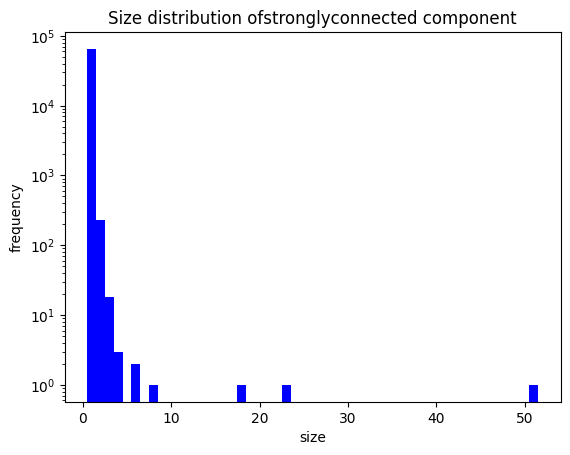

In [192]:
show_size_plot(size_frequency_strongly, 'strongly')

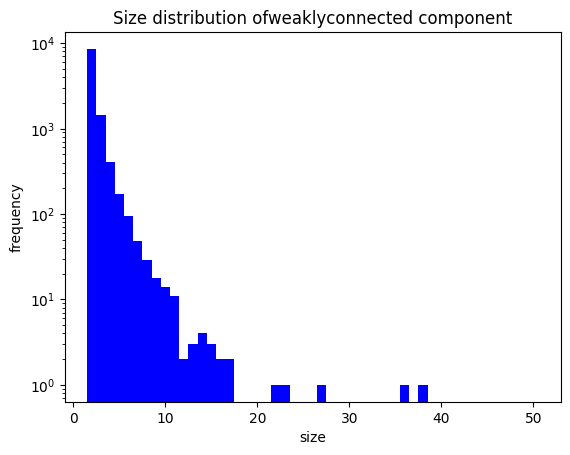

In [193]:
show_size_plot(size_frequency_weakly, 'weakly')

#### 3.3.3

In [194]:
print(nx.density(Gs))

1.5839531794836163e-05


#### 3.3.4

In [195]:
def get_degree_counts_list(G):
    counts = Counter(d for n, d in G.degree())
    return [counts.get(i, 0) for i in range(max(counts) + 1)]

In [196]:
Gs_degree_counts = get_degree_counts_list(Gs)

In [197]:
# show first 400 degree
def show_degree_plot(degree_count):
    y_counts = degree_count[:400]
    x_degrees = range(0, 400)

    f_p = plt.gca()
    # f_p.figure(figsize=(5, 5))
    f_p.bar(x_degrees, y_counts, width=1, color='b')
    f_p.set_yscale('log')
    plt.title("Size distribution of connected component")
    plt.ylabel("frequency")
    plt.xlabel("size")
    return 

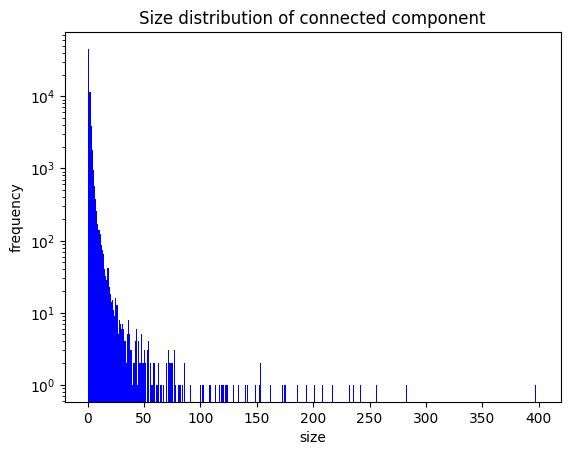

In [198]:
show_degree_plot(Gs_degree_counts)

#### 3.2.4

In [199]:
print(nx.average_clustering(Gs))

0.020247967107027136


#### 3.2.5

In [200]:
# directed gaint component
gaint_component = Gs.subgraph(max(nx.weakly_connected_components(Gs), key=len))
# undirected gaint component
# Gs_u = nx.read_adjlist("../datasets/twitter_small.csv", create_using=nx.Graph())
# undirct_gaint_component = Gs_u.subgraph(max(nx.weakly_connected_components(Gs_u), key=len))


In [317]:
spl = dict(nx.shortest_path_length(gaint_component))

In [341]:
a = nx.single_source_shortest_path_length(gaint_component, '0031pushpin')

In [344]:
a

{'0031pushpin': 0, 'TomTom': 1}

In [339]:
g = list(gaint_component)[0:10]
gg = Gs.subgraph(g)
spl = dict(nx.shortest_path_length(gg))

In [347]:
spl['007jbond']['playspymaster']

1

In [337]:
for i in gaint_component.nodes():
    nx.single_source_shortest_path_length(gaint_component, i)

[39665, 52543, 99740, 85044, 273661, 321194, 210545, 153592, 129705, 103718, 66183, 45225, 32201, 23169, 24398, 30458, 163613, 118776, 138697, 88469, 53920, 37306, 14199, 7215, 3121, 957, 306, 82, 12]


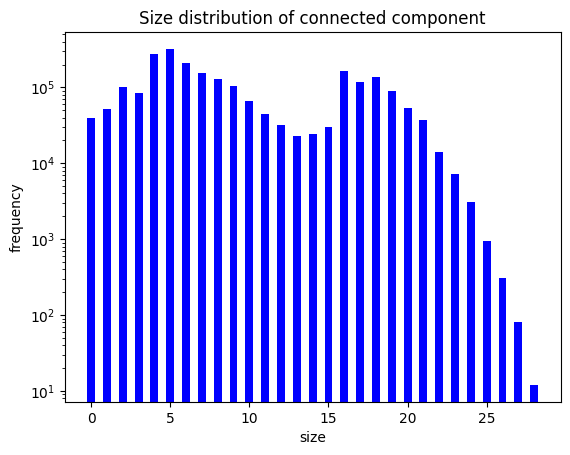

In [327]:

distance_list = []
sql_num = -1
for node in spl:
    distance_list.extend(list(spl[node].values()))
distance_number = []
ini = -1
for i in sorted(distance_list):
    if i == ini:
        continue
    ini = i
    distance_number.append(distance_list.count(i))
print(distance_number)
f_p = plt.gca()
# f_p.figure(figsize=(5, 5))
f_p.bar(range(0, len(distance_number), 1),distance_number, width=0.5, color='b')
f_p.set_yscale('log')
plt.title("Size distribution of connected component")
plt.ylabel("frequency")
plt.xlabel("size")
plt.show()


In [202]:
# show_distance_plot(Gs, gaint_component)


---

### 3.3

In [300]:
Gs = nx.read_adjlist("../datasets/twitter_small.csv", create_using=nx.DiGraph())

In [ ]:
# Top 20 degree
indeg_centrality_dict = nx.in_degree_centrality(Gs)
indeg_centrality_top_list = sorted(indeg_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:20]

for i in range(20):
    indeg_centrality_top_list[i] = indeg_centrality_top_list[i][0]

mark = 0
mark_dict = {}
re_indeg_centrality_top_list = []
for i in range(20):
    if indeg_centrality_top_list[i] in mark_dict.keys():
        re_indeg_centrality_top_list.append(mark_dict[indeg_centrality_top_list[i]])
    else:
        mark_dict[indeg_centrality_top_list[i]] = mark
        mark += 1
        re_indeg_centrality_top_list.append(mark_dict[indeg_centrality_top_list[i]])

# Top 20 closeness
closeness_centrality_dict = nx.closeness_centrality(Gs, u=None, distance=None, wf_improved=True)
closeness_centrality_top_list = sorted(closeness_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:20]

for i in range(20):
    closeness_centrality_top_list[i] = closeness_centrality_top_list[i][0]

re_closeness_centrality_top_list = []
for i in range(20):
    if closeness_centrality_top_list[i] in mark_dict.keys():
        re_closeness_centrality_top_list.append(mark_dict[closeness_centrality_top_list[i]])
    else:
        mark_dict[closeness_centrality_top_list[i]] = mark
        mark += 1
        re_closeness_centrality_top_list.append(mark_dict[closeness_centrality_top_list[i]])

In [301]:
# Top 20 degree
indeg_centrality_dict = nx.in_degree_centrality(Gs)
indeg_centrality_top_list = sorted(indeg_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:20]

for i in range(20):
    indeg_centrality_top_list[i] = indeg_centrality_top_list[i][0]

In [302]:
mark = 0
mark_dict = {}
re_indeg_centrality_top_list = []
for i in range(20):
    if indeg_centrality_top_list[i] in mark_dict.keys():
        re_indeg_centrality_top_list.append(mark_dict[indeg_centrality_top_list[i]])
    else:
        mark_dict[indeg_centrality_top_list[i]] = mark
        mark += 1
        re_indeg_centrality_top_list.append(mark_dict[indeg_centrality_top_list[i]])


In [303]:
re_indeg_centrality_top_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [305]:
# # Top 20 betweenness (Running by gephi)
# betweenness_centrality_dict = nx.betweenness_centrality(Gs, k=None, normalized=True, weight=None, endpoints=False, seed=None)
# betweenness_centrality_top_list = sorted(betweenness_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:20]
tsvfile =  open("../datasets/small_centrality_Gephi.csv")
tsvReader = [each for each in csv.reader(tsvfile, delimiter=',')]
tsvfile.close()
betweenness_centrality_top_list = {}
tsvReader = tsvReader[1:]
for i in tsvReader:
    betweenness_centrality_top_list[i[0]] = float(i[-1])
betweenness_centrality_top_list = sorted(betweenness_centrality_top_list.items(), key=lambda x: x[1], reverse=True)[:20]

for i in range(20):
    betweenness_centrality_top_list[i] = betweenness_centrality_top_list[i][0]


In [306]:
re_betweenness_centrality_top_list = []
for i in range(20):
    if betweenness_centrality_top_list[i] in mark_dict.keys():
        re_betweenness_centrality_top_list.append(mark_dict[betweenness_centrality_top_list[i]])
    else:
        mark_dict[betweenness_centrality_top_list[i]] = mark
        mark += 1
        re_betweenness_centrality_top_list.append(mark_dict[betweenness_centrality_top_list[i]])

In [307]:
re_betweenness_centrality_top_list

[0, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 16, 34, 35, 36, 37]

In [308]:
# Top 20 closeness
closeness_centrality_dict = nx.closeness_centrality(Gs, u=None, distance=None, wf_improved=True)
closeness_centrality_top_list = sorted(closeness_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:20]

for i in range(20):
    closeness_centrality_top_list[i] = closeness_centrality_top_list[i][0]

In [309]:
re_closeness_centrality_top_list = []
for i in range(20):
    if closeness_centrality_top_list[i] in mark_dict.keys():
        re_closeness_centrality_top_list.append(mark_dict[closeness_centrality_top_list[i]])
    else:
        mark_dict[closeness_centrality_top_list[i]] = mark
        mark += 1
        re_closeness_centrality_top_list.append(mark_dict[closeness_centrality_top_list[i]])

In [310]:
re_closeness_centrality_top_list

[0, 1, 2, 6, 33, 19, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 21, 48, 49, 50]

In [311]:
print(stats.spearmanr(indeg_centrality_top_list, betweenness_centrality_top_list))
print(stats.spearmanr(indeg_centrality_top_list, closeness_centrality_top_list))
print(stats.spearmanr(betweenness_centrality_top_list, closeness_centrality_top_list))

SpearmanrResult(correlation=0.13984962406015036, pvalue=0.5564935505662203)
SpearmanrResult(correlation=0.17744360902255638, pvalue=0.4542034838793192)
SpearmanrResult(correlation=0.19548872180451127, pvalue=0.40881908952023194)


way to compare the similarity of the rankings

---

### 3.4  
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html

In [316]:
gaint_component = Gs.subgraph(max(nx.weakly_connected_components(Gs), key=len))
communities_generator = greedy_modularity_communities(gaint_component, weight=None, resolution=1, cutoff=1, best_n=None, n_communities=None)

In [328]:
communities_generator

[frozenset({'mambadt',
            'happytown09',
            'noodleheadpig',
            'webdesign_news',
            'hmbise',
            'TimboReid',
            'guruchill',
            'deanburge',
            'ugod',
            'austinbusiness',
            'janeorganise',
            'storylet',
            'big_tex_uk',
            'jasonpaul',
            'xmellyssax',
            'scottyjws',
            'SUBERAPPS',
            'Bubbasfood',
            'kahugary',
            'twangu',
            'courtenaybird',
            'derekmelton',
            'leejorgensen',
            'steveyurk',
            'mikebullman',
            'mchiaviello',
            'trendynutrition',
            'tamiro18',
            'heads5150',
            'dhinchcliffe',
            'txags00',
            'bpinaud',
            'acce',
            'GadgetsBlog',
            'JohnMcGuinness',
            'innov8ive',
            'chrisguillebeau',
            'kwilson9austin',
            '

---

### 3.5

In [ ]:
gaint_component = Gs.subgraph(max(nx.weakly_connected_components(Gs), key=len))

tsvfile =  open("../datasets/twitter_weight_small.csv")
tsvReader = [each for each in csv.reader(tsvfile, delimiter=' ')]
tsvfile.close()
tsvReader = tsvReader[1:]

gaint_component_dict = {}
with open("../datasets/twitter_gaint_small.csv","w") as csvWrite: 
    nwriter = csv.writer(csvWrite,delimiter=' ')
    nwriter.writerow(['Source', 'Target', 'Weight', 'Timestamp'])
    for i in gaint_component.edges():
        key = (i[0], '@' + i[1])
        if key in Gs_dic.keys():
            weight = Gs_dic[key]
            nwriter.writerow([i[0], i[1], weight[1], preprocessing_Timestamp(weight[0])])
csvWrite.close()

---

### 3.6

In [348]:
# load large csv
tsvfile =  open("../datasets/twitter-larger.tsv", encoding='gb18030', errors='ignore')
tsvReader = [each for each in csv.reader(tsvfile, delimiter='\t')]
tsvfile.close()

In [349]:
# edges_weights_dictionary
Gl_dic = {}
for row in tsvReader:
    # row[0] : timestamp
    # row[1] : user
    # row[2] : tweet
    mention = find_all_user(row[2])
    if mention != -1:
        for each in mention:
            if len(each) != 0:
                if (row[1], each) not in Gl_dic.keys():
                    Gl_dic[(row[1], each)] = [row[0], 1]
                else:
                    Gl_dic[(row[1], each)][1] += 1

In [350]:
# edge .csv without weights
with open("../datasets/twitter_large.csv","w") as csvWrite: 
    nwriter = csv.writer(csvWrite,delimiter=' ')
    nwriter.writerow(['Source', 'Target'])
    for key in sorted(Gl_dic.keys()):
        timestamp = preprocessing_Timestamp(Gl_dic[key][0])
        if (key[0] != '') & (key[1][1:] != '') & (key[0] != key[1][1:]):
            nwriter.writerow([key[0],key[1][1:]])

csvWrite.close()

In [351]:
Gl = nx.read_adjlist("../datasets/twitter_large.csv", create_using=nx.DiGraph())


In [355]:
gaint_component_Gl = Gl.subgraph(max(nx.weakly_connected_components(Gl), key=len))


In [356]:
print(nx.single_source_shortest_path_length(gaint_component_Gl, '001d7'))

{'001d7': 0, 'Kyodog': 1, 'te2wo': 1}


In [357]:
gaint_component_Gl.number_of_nodes()

498091

In [359]:
import igraph as ig


In [364]:
gl = ig.Graph.from_networkx(gaint_component_Gl)


In [389]:
gs = ig.Graph.from_networkx(Gs)

In [418]:
estimate = gl.betweenness()


In [435]:
betweenness_centrality_top_list = {}
count = 0
for i in gl.vs:
    betweenness_centrality_top_list[i['_nx_name']] = estimate[count]
    count += 1

In [441]:
gl.vs['_nx_name'][1]

'TCEurope'

In [445]:
# gl.get_all_shortest_paths(gl.vs['_nx_name'][1], to=None, weights=None, mode='out')

In [446]:
betweenness_centrality_top_list = sorted(betweenness_centrality_top_list.items(), key=lambda x: x[1], reverse=True)[:20]

for i in range(20):
    betweenness_centrality_top_list[i] = betweenness_centrality_top_list[i][0]
re_betweenness_centrality_top_list = []
for i in range(20):
    if betweenness_centrality_top_list[i] in mark_dict.keys():
        re_betweenness_centrality_top_list.append(mark_dict[betweenness_centrality_top_list[i]])
    else:
        mark_dict[betweenness_centrality_top_list[i]] = mark
        mark += 1
        re_betweenness_centrality_top_list.append(mark_dict[betweenness_centrality_top_list[i]])

In [448]:
# Top 20 degree
indeg_centrality_dict = nx.in_degree_centrality(Gl)
indeg_centrality_top_list = sorted(indeg_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:20]

for i in range(20):
    indeg_centrality_top_list[i] = indeg_centrality_top_list[i][0]

# Top 20 closeness
closeness_centrality_dict = nx.closeness_centrality(Gl, u=None, distance=None, wf_improved=True)
closeness_centrality_top_list = sorted(closeness_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:20]

for i in range(20):
    closeness_centrality_top_list[i] = closeness_centrality_top_list[i][0]

In [447]:
betweenness_centrality_top_list

['uberguineapig',
 'razorianfly',
 'taptaptap',
 'mmartel',
 'theiphoneblog',
 'marcoarment',
 'appbank',
 'tommytrc',
 'iphonegirl',
 'simplytweet',
 'adriarichards',
 'tweetmeme',
 'ikeafans',
 'iphone_dev',
 'iphone_mob',
 'filjedi',
 'iphonefan',
 'dudeman718',
 'iphoneincanada',
 'prosam']

In [416]:
# i = 0
# sum = 0
# for key in betweenness_centrality_top_list.keys():
#     sum += (estimate_s[i] - betweenness_centrality_top_list[key])
#     print(estimate_s[i], '  ' ,betweenness_centrality_top_list[key])
#     i += 1

0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.5    0.5
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
275.0    275.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
300.0    300.0
54.0    54.0
78.0    78.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
1.0    1.0
0.0    0.0
0.0    0.0
0.0    0.0
1.0    1.0
0.0    0.0
0.0    0.0
0.0    0.0
1.0    1.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
497.0    497.0
12.0    12.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
24.0    24.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
0.0    0.0
3.0    3.0
0.0    0.0
7908.083333333337    7908.083333
0.0    0.0
0.0    0.0
7105.266666666666    7105.266667
0.0    0.0
40.0    40.0